In [1]:
import pandas as pd

import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

November 2018

Detta är en trendidé till tidningen. Hans nämnde att vi borde kolla läkemedelskostnaderna hos landstingen. Följande data fick jag genom SKL. På deras hemsida finns info om kostnader per månad, dock endast i powerpointpresentationer(???). Men efter att ha fått tag på en kontakt på SKL har jag fått data per landsting sedan 2001! På webben [hittar man artikeln här](https://www.dagenssamhalle.se/nyhet/utgifterna-medicin-fortsatter-att-stiga-25358). I tidningen publicerades texten på trendsidan i nummer 44, 2018.

In [2]:
df = pd.read_excel('data/data_skl.xlsx',header=10).iloc[1:,3:-1].dropna().reset_index()

In [3]:
df = df.set_index('index').iloc[:,-5:].reset_index()

In [4]:
df['index'] = df['index'].str.extract(".* - (.*) - .*").fillna("Riket")

In [5]:
df = df.rename(columns={'index':'region'})

In [6]:
df = df.melt(id_vars='region',var_name='år',value_name='värde')

**Anpassning efter befolkningsmängd:**

In [7]:
befolkning = pd.read_excel('data/befolkning.xls').rename(columns={'landsting':'region','värde':'befolkning'})

Liter kolumnformattering:

In [8]:
befolkning.region = befolkning.region.str.replace("Landstinget i ","")\
                                            .str.replace(" län","")\
                                            .str.replace("Region ","")\
                                            .str.replace("Landstinget ","")\
                                            .str.replace("s landsting","")\
                                            .str.replace("sregionen","")\
                                            .str.replace("Stockholms","Stockholm")\
                                            .str.replace("Västerbottens","Västerbotten")\
                                            .str.strip()\
                                            .str.replace("Jämtland Härjedalen","Jämtland")\
                                            .str.replace('Jönköpings','Jönköping')\
                                            .str.replace('Sörmland','Södermanland')

Dataformattering:

In [9]:
for col in ['år','värde']:
    df[col] = pd.to_numeric(df[col])

In [10]:
df = df.merge(befolkning,on=['region','år'],how='left')

Beräkning kronor per invånare:

In [11]:
df['kr_inv'] = df['värde']/df['befolkning']

In [12]:
df = df.pivot(index='region',columns='år',values='kr_inv')

Beräkning av kostnadsökning 2013-2017. Efter samtal med SKL så fick jag reda på att man _inte_ bör beräkna kostnadsökningen på KPI, **utan snarare läkemedelskostnadsindex**, vilket under perioden 2013-2017 minskade med 3,1 procent. Därav minus -0,0031 i nedan beräkning:

In [13]:
df['kostnadsökning 2013-2017, %'] = ((((df.iloc[:,-1]-(df.iloc[:,-1]*(-0.031)))/df.iloc[:,0])-1)*100).round(1)

In [14]:
os.makedirs('res')

In [15]:
df.to_excel('res/resultat_korrekt.xlsx')

**Tidigare beräkningar**

Följande är bara kvar från när jag lekte med data för att analysera utvecklingen per region. Har ingen övrig betydelse.

In [169]:
df = pd.read_excel('data/data_skl.xlsx',header=10).iloc[1:,3:-1].dropna().reset_index()

In [170]:
df = df.set_index('index').iloc[:,-5:].reset_index()

In [171]:
df['index'] = df['index'].str.extract(".* - (.*) - .*").fillna("Riket")

In [172]:
df = df.rename(columns={'index':'region'})

In [173]:
df = df.melt(id_vars='region',var_name='år',value_name='värde')

In [174]:
df.värde = pd.to_numeric(df.värde)

In [175]:
df = df.pivot_table(index='region',columns='år')
df.columns = df.columns.droplevel(0)

In [176]:
df = df/1000000000

In [177]:
for col in df.columns:
    df[col] = df[col].apply(lambda x: round(x,4))

In [178]:
series = pd.to_numeric(df.iloc[:,0])

In [179]:
df.head()

år,2013,2014,2015,2016,2017
region,,,,,
Blekinge,0.3159,0.3243,0.3424,0.3721,0.3994
Dalarna,0.5859,0.5930,0.6261,0.6666,0.7138
Gotland,0.1287,0.1315,0.1416,0.1539,0.1676
Gävleborg,0.6129,0.6192,0.6468,0.7096,0.7478
Halland,0.6536,0.6707,0.7226,0.8007,0.8481


In [180]:
series = pd.to_numeric(df.iloc[:,0])
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col])
    df[col] = (((df[col]/series)-1)*100).round(1)
df.iloc[:,0] = 0

In [181]:
df.head()

år,2013,2014,2015,2016,2017
region,,,,,
Blekinge,0,2.7,8.4,17.8,26.4
Dalarna,0,1.2,6.9,13.8,21.8
Gotland,0,2.2,10.0,19.6,30.2
Gävleborg,0,1.0,5.5,15.8,22.0
Halland,0,2.6,10.6,22.5,29.8


In [182]:
df = df.reset_index().melt(id_vars='region',var_name='år')

**Kostnadsutveckling i procent per region:**

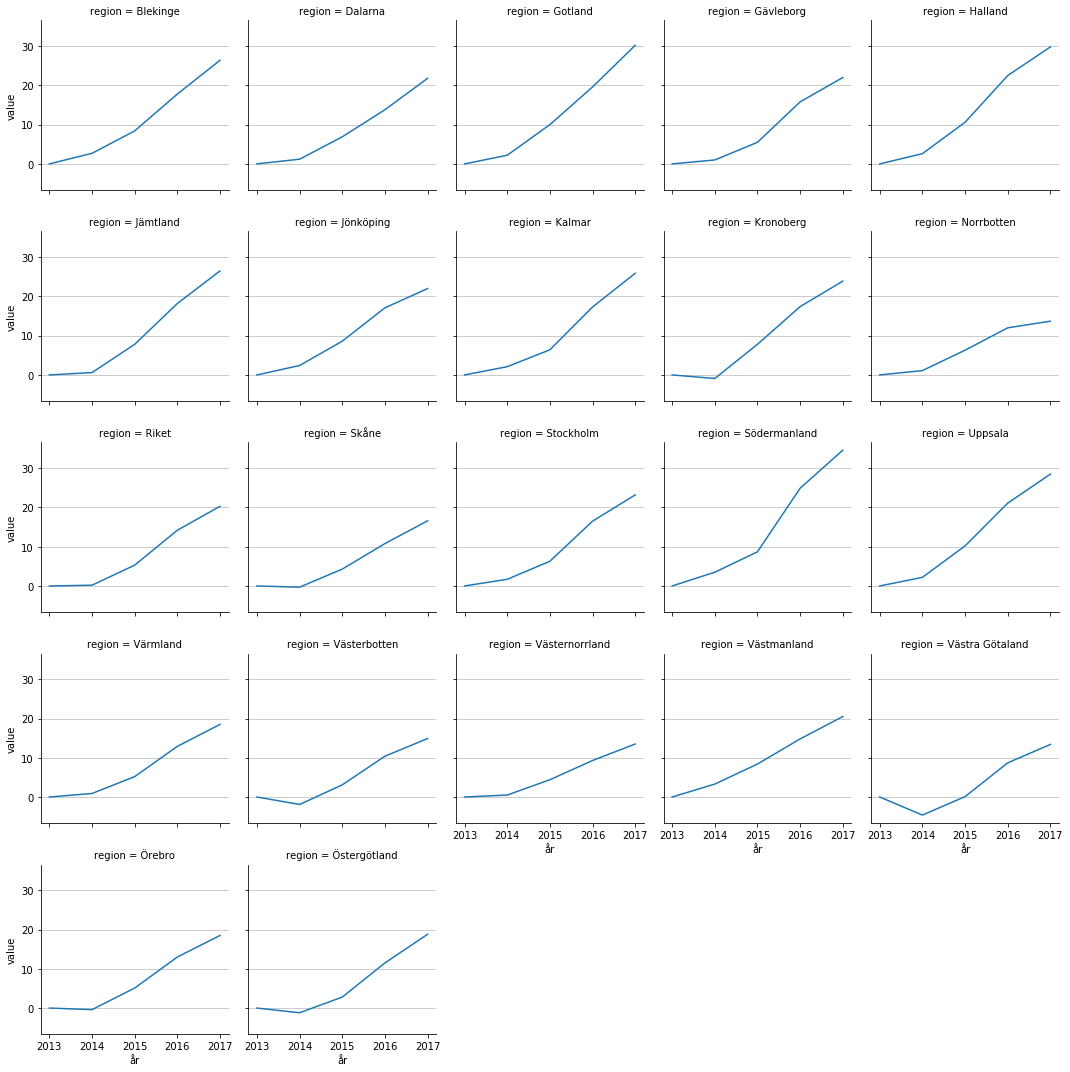

In [183]:
g = sns.FacetGrid(df,col='region',col_wrap=5)
g.map(plt.plot,'år','value')

for a in g.axes:
    a.grid(True, axis='y', alpha=0.5, color='grey')